In [5]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *
from tqdm import tqdm

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy 

In [6]:
X, y, le = read_data(dataset)

In [7]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for all the data

In [8]:
X_train, y_train = X, y
clf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

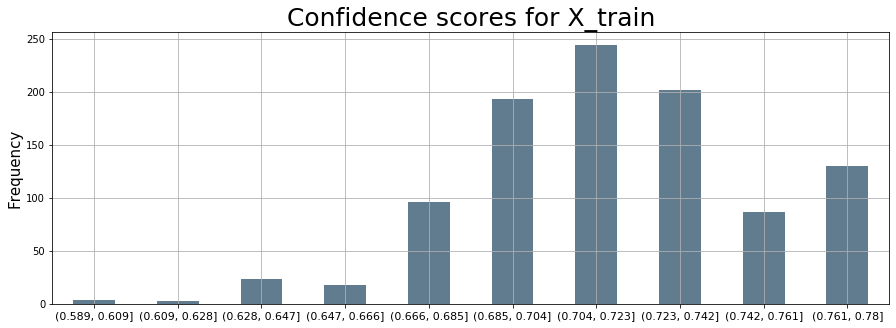

In [9]:
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Select C as the middle of top intervals

In [10]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

In [11]:
top_c_lst 

[0.599, 0.6185, 0.6375, 0.6565, 0.6755, 0.6945, 0.7135, 0.7325, 0.7515, 0.7705]

# D. Train 10 CTGANs with middle of intervals

In [8]:
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all 
X_train_pd = pd.DataFrame(X_train)

for c in top_c_lst:
    
    # train CTGAN
    z_features = get_noise_features(X_train, categorical_features)
    z_rows = int(0.25 * X_train.shape[0])
    z = gen_random_noise(shape=(z_rows, z_features))

    batch_size = 50
    epochs = 50
    confidence_level = c
    gen_lr = 2e-5
    loss = 'log'

    
    rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                                blackbox_model=rf,
                                preprocessing_pipeline=preprocessor,
                                bb_loss=loss
                                )

    print(f"Training CTGAN for c = {c}...")
    hist = rf_ctgan.fit(train_data=z,
                        epochs=epochs,
                        confidence_level=confidence_level,
                        gen_lr=gen_lr,
                        verbose=False
                        )

    # rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
    # plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
    # print()
    
    
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    
    
    # ans is the indices of gen_data to make the same dist 
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]
        
    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    gen_data_inv = pd.DataFrame(gen_data_inv)
    
    # y_conf_gen_same_dist, gen_data_inv what we want
    # results
    # E. Calculate coverage for each similarity and conf diff thresholds
    print(f"\tWorking on results...")
    results = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)
    print(f"\tResults for confidence level = {c}")
    display(results)

Training CTGAN for c = 0.599...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.599


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 94.3,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0
0.85,100.0 | 92.4,100.0 | 94.5,100.0 | 94.5,100.0 | 94.5,100.0 | 94.5
0.90,100.0 | 89.2,100.0 | 92.1,100.0 | 92.1,100.0 | 92.1,100.0 | 92.1
0.95,100.0 | 81.7,100.0 | 87.5,100.0 | 87.6,100.0 | 87.6,100.0 | 87.6
0.99,60.1 | 50.6,89.9 | 70.9,91.0 | 71.1,91.3 | 71.2,91.3 | 71.2


Training CTGAN for c = 0.6185...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6185


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.3,100.0 | 96.7,100.0 | 96.7,100.0 | 96.7,100.0 | 96.7
0.85,100.0 | 95.6,100.0 | 96.3,100.0 | 96.3,100.0 | 96.3,100.0 | 96.3
0.90,100.0 | 94.3,100.0 | 94.9,100.0 | 95.0,100.0 | 95.0,100.0 | 95.0
0.95,100.0 | 86.9,100.0 | 90.9,100.0 | 91.1,100.0 | 91.1,100.0 | 91.1
0.99,38.5 | 38.8,78.9 | 60.9,85.3 | 62.3,86.2 | 62.3,86.2 | 62.4


Training CTGAN for c = 0.6375...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6375


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 72.1,100.0 | 75.0,100.0 | 75.9,100.0 | 75.9,100.0 | 75.9
0.85,100.0 | 68.1,100.0 | 71.8,100.0 | 72.5,100.0 | 72.5,100.0 | 72.5
0.90,100.0 | 63.4,100.0 | 66.7,100.0 | 67.4,100.0 | 67.4,100.0 | 67.4
0.95,99.7 | 51.0,100.0 | 58.0,100.0 | 58.9,100.0 | 58.9,100.0 | 58.9
0.99,25.6 | 23.2,85.1 | 33.0,91.2 | 34.0,91.2 | 34.0,91.2 | 34.0


Training CTGAN for c = 0.6565...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6565


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 72.5,100.0 | 74.7,100.0 | 74.7,100.0 | 74.7,100.0 | 74.7
0.85,100.0 | 65.5,100.0 | 68.4,100.0 | 68.5,100.0 | 68.5,100.0 | 68.5
0.90,100.0 | 56.6,100.0 | 60.0,100.0 | 60.1,100.0 | 60.1,100.0 | 60.1
0.95,99.6 | 46.4,100.0 | 49.8,100.0 | 49.9,100.0 | 49.9,100.0 | 49.9
0.99,43.1 | 23.8,85.7 | 30.6,89.2 | 30.9,89.3 | 31.0,89.3 | 31.0


Training CTGAN for c = 0.6755...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6755


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 82.4,100.0 | 83.5,100.0 | 83.5,100.0 | 83.5,100.0 | 83.5
0.85,100.0 | 78.2,100.0 | 79.8,100.0 | 80.0,100.0 | 80.0,100.0 | 80.0
0.90,100.0 | 73.3,100.0 | 75.0,100.0 | 75.3,100.0 | 75.3,100.0 | 75.3
0.95,100.0 | 61.9,100.0 | 64.8,100.0 | 65.5,100.0 | 65.5,100.0 | 65.5
0.99,67.5 | 32.7,87.9 | 41.5,90.1 | 42.2,90.2 | 42.2,90.2 | 42.2


Training CTGAN for c = 0.6945...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6945


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 88.3,100.0 | 89.3,100.0 | 89.7,100.0 | 89.7,100.0 | 89.7
0.85,100.0 | 85.2,100.0 | 86.4,100.0 | 86.8,100.0 | 86.8,100.0 | 86.8
0.90,100.0 | 81.2,100.0 | 82.8,100.0 | 82.9,100.0 | 82.9,100.0 | 82.9
0.95,100.0 | 73.8,100.0 | 76.9,100.0 | 77.0,100.0 | 77.0,100.0 | 77.0
0.99,44.8 | 38.4,83.4 | 51.8,85.5 | 53.2,86.4 | 53.6,86.6 | 53.6


Training CTGAN for c = 0.7135...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7135


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 81.5,100.0 | 84.8,100.0 | 84.8,100.0 | 84.8,100.0 | 84.8
0.85,100.0 | 78.2,100.0 | 81.3,100.0 | 81.3,100.0 | 81.3,100.0 | 81.3
0.90,100.0 | 73.7,100.0 | 77.3,100.0 | 77.4,100.0 | 77.4,100.0 | 77.4
0.95,100.0 | 65.8,100.0 | 69.5,100.0 | 69.7,100.0 | 69.7,100.0 | 69.7
0.99,53.7 | 35.9,86.5 | 50.0,90.2 | 51.0,90.2 | 51.0,90.2 | 51.0


Training CTGAN for c = 0.7325...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7325


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 63.2,100.0 | 65.6,100.0 | 66.1,100.0 | 66.1,100.0 | 66.1
0.85,100.0 | 58.5,100.0 | 61.2,100.0 | 61.7,100.0 | 61.7,100.0 | 61.7
0.90,100.0 | 52.5,100.0 | 55.6,100.0 | 55.8,100.0 | 55.8,100.0 | 55.8
0.95,100.0 | 41.9,100.0 | 47.5,100.0 | 47.9,100.0 | 47.9,100.0 | 47.9
0.99,40.7 | 16.9,78.7 | 27.2,82.7 | 28.1,82.7 | 28.2,82.7 | 28.2


Training CTGAN for c = 0.7515...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7515


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 85.5,100.0 | 85.8,100.0 | 85.8,100.0 | 85.8,100.0 | 85.8
0.85,100.0 | 80.3,100.0 | 81.3,100.0 | 81.3,100.0 | 81.3,100.0 | 81.3
0.90,100.0 | 74.5,100.0 | 75.7,100.0 | 75.7,100.0 | 75.7,100.0 | 75.7
0.95,100.0 | 60.6,100.0 | 63.8,100.0 | 64.2,100.0 | 64.2,100.0 | 64.2
0.99,36.2 | 25.6,85.8 | 36.4,89.4 | 37.9,89.4 | 37.9,89.7 | 38.0


Training CTGAN for c = 0.7705...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7705


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 93.6,100.0 | 95.1,100.0 | 95.2,100.0 | 95.2,100.0 | 95.2
0.85,100.0 | 91.2,100.0 | 93.4,100.0 | 93.4,100.0 | 93.4,100.0 | 93.4
0.90,100.0 | 87.9,100.0 | 90.7,100.0 | 90.8,100.0 | 90.8,100.0 | 90.8
0.95,99.9 | 80.8,100.0 | 85.4,100.0 | 85.9,100.0 | 85.9,100.0 | 85.9
0.99,64.2 | 50.4,91.0 | 67.7,91.6 | 69.3,91.7 | 69.3,91.7 | 69.3
